# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Задача: **необходимо построить модель, которая по фотографии определит приблизительный возраст человека**. В моём распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
# Импорт необходимых библиотек

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Распакуем наши данные и посмотрим на размер представленного DF (выборки)
data = pd.read_csv('/datasets/faces/labels.csv')
display(data.head())
data.info(memory_usage=True)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


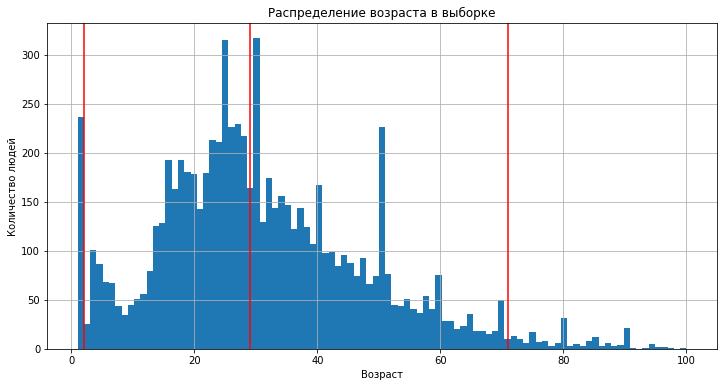

array([ 2., 29., 71.])

In [3]:
# Визуализация распределения возраста в выборке

plt.figure(figsize=(12, 6))
plt.hist(data['real_age'], bins = data['real_age'].nunique())
plt.grid(True)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество людей')

# вычисляем квантили 2.5%, 50% и 97.5%
quantiles = np.percentile(data['real_age'], [2.5, 50, 97.5])

# отображаем вертикальные линии на гистограмме для каждого квантиля
for q in quantiles:
    plt.axvline(x=q, color='r')

# отображаем гистограмму и квантили
plt.show()
quantiles

Found 149 validated image filenames.


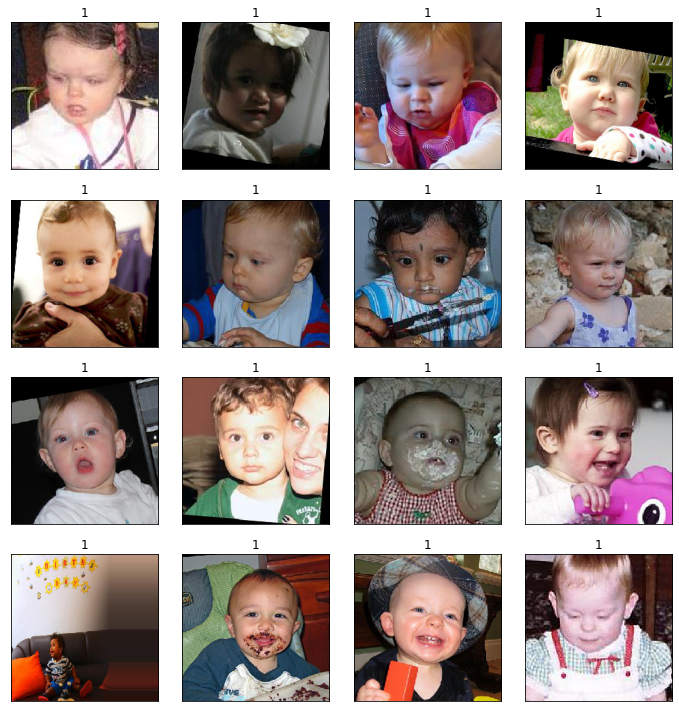

In [4]:
# Посмотрим на 16 изображений людей, которые меньше 1 квантиль (обеспокоил данный столбец, который выбивется из основного распределения)

data_q1 = data.loc[data.real_age < 2.]

q1_datagen = ImageDataGenerator(rescale=1./255)
q1_gen_flow = q1_datagen.flow_from_dataframe(
        dataframe=data_q1,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)


q1_features, q1_target = q1_gen_flow.next()

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(q1_features[i])
    plt.title(q1_target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Found 7591 validated image filenames.


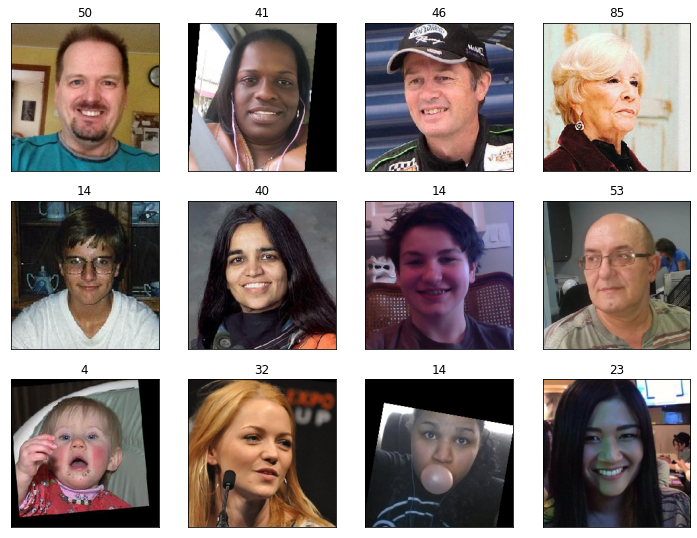

In [5]:
# Посмотрим на 12 изображений

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

features_train, target_train = train_gen_flow.next()

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features_train[i])
    plt.title(target_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Выводы

Нам был предоставлен DF, в котором находится 7591 наблюдение, общим весом в 119 Кб:
- file_name - путь до изображения
- real_age - реальный возраст человека, изображённого на картинке

Если говорить про возраст - данная колонка имеет распределение Гаусса с положительным смещением. В среднем нам представлены фотографии людей 17 - 35 лет, также весьма большое количество детей в возрасте 1 года. Необходимо провести аугментацию данных, для расширения выборки.

## Обучение модели

Обучение происходило на CNN ResNet50, которая очень устойчива к проблеме взрыва и затухания градиента. Для этого была произведена тонкая настройка модели с удалением полносвязных слоёв, которые в дальнейшем были распределены под нашу задачу регрессии.

In [6]:
def load_train(path):
    data = pd.read_csv(path + 'labels.csv')

    datagen_train = ImageDataGenerator(rescale=1. / 255,
                                       validation_split=0.2,
                                       vertical_flip=True,
                                       horizontal_flip=True)

    train_datagen_flow = datagen_train.flow_from_dataframe(directory=path + 'final_files/',
                                                           dataframe=data,
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=16,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345)

    return train_datagen_flow


def load_test(path):
    data = pd.read_csv(path + 'labels.csv')

    datagen_valid = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

    validation_datagen_flow = datagen_valid.flow_from_dataframe(directory=path + 'final_files/',
                                                                dataframe=data,
                                                                x_col='file_name',
                                                                y_col='real_age',
                                                                target_size=(224, 224),
                                                                batch_size=16,
                                                                subset='validation',
                                                                class_mode='raw',
                                                                seed=12345)

    return validation_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        include_top=False,
                        weights='imagenet')

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001), metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

Train for 380 steps, validate for 95 steps

Epoch 1/10

380/380 - 50s - loss: 231.1141 - mae: 11.1134 - val_loss: 587.6054 - val_mae: 19.1071

Epoch 2/10

380/380 - 46s - loss: 115.4944 - mae: 8.1547 - val_loss: 133.8245 - val_mae: 8.8173

Epoch 3/10

380/380 - 46s - loss: 90.6988 - mae: 7.2149 - val_loss: 123.7711 - val_mae: 8.4016

Epoch 4/10

380/380 - 46s - loss: 72.5860 - mae: 6.5385 - val_loss: 100.4960 - val_mae: 7.4803

Epoch 5/10

380/380 - 47s - loss: 61.6787 - mae: 6.0000 - val_loss: 85.6535 - val_mae: 6.8547

Epoch 6/10

380/380 - 46s - loss: 50.2128 - mae: 5.4644 - val_loss: 80.7605 - val_mae: 6.7637

Epoch 7/10

380/380 - 45s - loss: 45.2093 - mae: 5.1513 - val_loss: 82.9066 - val_mae: 6.7547

Epoch 8/10

380/380 - 47s - loss: 40.9843 - mae: 4.8983 - val_loss: 90.6431 - val_mae: 7.1175

Epoch 9/10

380/380 - 46s - loss: 36.4018 - mae: 4.6066 - val_loss: 84.1167 - val_mae: 7.0214

Epoch 10/10

380/380 - 47s - loss: 30.5017 - mae: 4.2547 - val_loss: 86.4531 - val_mae: 7.0981


95/95 - 9s - loss: 86.4531 - mae: 7.0981

**Test MAE: 7.0981**

## Анализ обученной модели

Данная модель обучалась на специальных серверах GPU, что позволило нам сэкономить время на тренировке и подгонке весов. Однако мы не можем посмотреть предсказания и построить тепловые карты для более детальной аналитики нашего алгоритма. 

Благодаря тонкой настройке мы поменяли работу заранее обученной нейросети ResNet50 (датасет imagenet) под нашу задачу. С точки зрения бизнеса, использование зоопарка моделей Keras позволяет закрывать многие задачи, обучая модели на небольших наборах данных не за месяцы, а всего за несколько часов, чем мы и воспользовались. Я не стал брать нулевые веса, тк это привело бы к потери точности. В данной ситуации лучше всего было обучить CNN на её весах, заменив лишь классификатор.

Значение нашей метрики спустя 10 эпох смогло достигнуть 4.2547 на валидационной выборке. На тесте же модель показала метрику равную 7.0981, что является хорошим результатом. Отклонение в 2-3 года будет весомым лишь при покупке алкоголя. Для более точной оценки необходим DF с бОльшим количеством наблюдений, тк аугментация порой сбивает алгоритм с толку.